
# Prerequisites – Download nltk stopwords and spacy model

In [73]:
# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/georgetanev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import Packages


In [74]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [75]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [76]:
# spacy for lemmatization
import spacy

In [77]:

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [79]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [80]:
spacy.load("en_core_web_sm")
from spacy.lang.en import English

parser = English()

In [81]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    # tokens = [get_lemma(token) for token in tokens]
    return tokens


def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens


def getDocTopicWeight(lda_model_in, new_doc):
    doc = prepare_text_for_lda(new_doc)
    new_doc_bow = id2word.doc2bow(doc)
    return lda_model_in.get_document_topics(new_doc_bow)


# Define functions for stopwords,
def remove_stopwords(texts_in):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_in]


# Set # of Topics

In [82]:
num_topics=30

# Prepare Stopwords

In [83]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Assrtions Data

In [84]:
df = pd.read_csv('230 VP assertions corpus - Group 6.csv')

In [85]:
df.head()

,name,content
0,G6A002,Access resources required to scale at relative...
1,A003,Adapt offers to each market
2,A005,"Align interests of investors, the company top ..."
3,A006,Allow resource owners to make money using your...
4,A007,Apply big data analytics to produce insightful...


# Data pre-processing

In [86]:
# Convert to list
data = df.content.values.tolist()

In [87]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [88]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [89]:
pprint(data[:1])

['Access resources required to scale at relatively low cost or for free by '
 'creating benefits for the resource owners that they cannot create alone']


# Remove Stopwords

In [90]:
# Define functions for stopwords, 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [91]:
# Remove Stop Words
data_nostops = remove_stopwords(data)

In [92]:
pprint(data[:1])

['Access resources required to scale at relatively low cost or for free by '
 'creating benefits for the resource owners that they cannot create alone']


# Create the Dictionary and Corpus needed for Topic Modeling

In [93]:
# Create Dictionary
id2word = corpora.Dictionary(data_nostops)

In [94]:
# Create Corpus
texts = data_nostops

In [95]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [96]:

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [97]:
id2word[0]

'access'

In [98]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('access', 1),
  ('alone', 1),
  ('benefits', 1),
  ('cannot', 1),
  ('cost', 1),
  ('create', 1),
  ('creating', 1),
  ('free', 1),
  ('low', 1),
  ('owners', 1),
  ('relatively', 1),
  ('required', 1),
  ('resource', 1),
  ('resources', 1),
  ('scale', 1)]]

# Building the Topic Model

In [99]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [100]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(-1))
doc_lda = lda_model[corpus]

[(0,
  '0.217*"achieve" + 0.084*"help" + 0.055*"determine" + 0.055*"power" + '
  '0.018*"fulfillment" + 0.008*"collaborate" + 0.008*"optimal" + '
  '0.008*"internet" + 0.008*"distinct" + 0.001*"pay"'),
 (1,
  '0.196*"customer" + 0.056*"communicate" + 0.049*"demonstrate" + '
  '0.044*"offers" + 0.036*"habits" + 0.029*"new" + 0.027*"deliver" + '
  '0.025*"experience" + 0.018*"buying" + 0.018*"technologies"'),
 (2,
  '0.190*"creation" + 0.154*"co" + 0.141*"enable" + 0.094*"customer" + '
  '0.044*"services" + 0.024*"feedback" + 0.011*"products" + 0.011*"offer" + '
  '0.004*"continuously" + 0.004*"support"'),
 (3,
  '0.161*"suppliers" + 0.078*"increase" + 0.061*"objectives" + 0.040*"enhance" '
  '+ 0.033*"scaling" + 0.030*"provide" + 0.027*"standards" + 0.027*"making" + '
  '0.026*"growth" + 0.026*"high"'),
 (4,
  '0.092*"delivery" + 0.077*"including" + 0.054*"quality" + '
  '0.041*"affiliations" + 0.041*"company" + 0.040*"deploy" + '
  '0.037*"information" + 0.035*"offers" + 0.021*"achieve

In [101]:
df_doctop = pd.DataFrame(np.zeros((len(data),num_topics),dtype=float), index=np.arange(len(data)), columns=[list(range(num_topics))])

# Visualize the topics-keywords

In [102]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.345633 -0.001933       1        1  13.307677
3      0.116454 -0.195345       2        1   9.334854
11     0.059052 -0.053222       3        1   6.030785
19     0.062888 -0.139560       4        1   5.752455
10    -0.047941  0.068519       5        1   5.668005
5     -0.005051 -0.079280       6        1   5.543548
26    -0.006119  0.104858       7        1   5.526545
6      0.196954  0.159729       8        1   4.175140
1      0.003684 -0.034148       9        1   3.684339
12    -0.006142 -0.045064      10        1   3.669278
13     0.011140 -0.009596      11        1   3.558540
22     0.104120  0.168255      12        1   3.310850
15     0.095381  0.039269      13        1   2.861096
25    -0.076415  0.033012      14        1   2.754322
20    -0.040203 -0.036244      15        1   2.716287
2     -0.036679  0.039859      16        1   2.602238
4     -0.011361 -0.056368      17        1   2.530816
27    -0.028116 -0.045731      18        1   2.276763
8     -0.078124  0.026938      19        1   2.158429
28     0.005994 -0.099519      20        1   1.926374
21    -0.078045  0.010828      21        1   1.771749
23    -0.075761  0.025328      22        1   1.754662
9     -0.066561  0.012557      23        1   1.369943
0     -0.077724  0.024204      24        1   1.276952
16    -0.074619  0.022429      25        1   1.254684
24    -0.052254  0.026992      26        1   1.158932
29    -0.062389  0.014889      27        1   1.026018
17    -0.057832 -0.003191      28        1   0.602638
14    -0.061286  0.011276      29        1   0.250184
18    -0.058678  0.010258      30        1   0.145897, topic_info=          Term        Freq       Total Category  logprob  loglift
121      value  103.000000  103.000000  Default  30.0000  30.0000
59   suppliers   49.000000   49.000000  Default  29.0000  29.0000
26        make   34.000000   34.000000  Default  28.0000  28.0000
37   customers   86.000000   86.000000  Default  27.0000  27.0000
36    customer   36.000000   36.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
25       allow    0.003944    2.963517  Topic30  -7.0917  -0.0920
26        make    0.003944   34.590896  Topic30  -7.0917  -2.5492
27       money    0.003944   11.692774  Topic30  -7.0917  -1.4646
28    products    0.003944   22.829083  Topic30  -7.0917  -2.1337
29    services    0.003944   20.703899  Topic30  -7.0917  -2.0360

[1210 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
346      10  0.695642          able
0         3  0.254192        access
0         4  0.762575        access
493      24  0.917138       achieve
506      17  0.792960  achievements
...     ...       ...           ...
72        8  0.201122          well
127       3  0.892880          wide
217       7  0.686494    widespread
269      14  0.896764          work
250       5  0.657703         zones

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 12, 20, 11, 6, 27, 7, 2, 13, 14, 23, 16, 26, 21, 3, 5, 28, 9, 29, 22, 24, 10, 1, 17, 25, 30, 18, 15, 19])

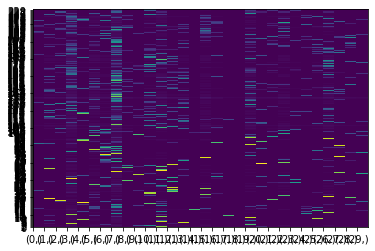

In [103]:
count=0

for a in data:
    doc_topic_weights = getDocTopicWeight(lda_model, a)
    for b in doc_topic_weights:
        # df_doctop = pd.DataFrame(b columns=range(20))
        df_doctop.at[count, b[0]] = b[1]

        # df_doctop.append(b[1]: doc_topic_weights)
    # print(doc_topic_weights[:][1])
    count=count+1

# Heatmap of weights
plt.pcolor(df_doctop)
plt.yticks(np.arange(0, len(df_doctop.index), 1), df_doctop.index)
plt.xticks(np.arange(0, len(df_doctop.columns), 1), df_doctop.columns)
plt.show()

df_doctop['Assertion']=data
df_doctop.to_csv("document_topic_weights.csv")

In [104]:
df_doctop

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Assertion
0,0.0,0.000000,0.000000,0.010988,0.0,0.000000,0.000000,0.013237,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Access resources required to scale at relative...
1,0.0,0.011843,0.010015,0.029945,0.0,0.019727,0.013382,0.035836,0.0,0.221895,...,0.00000,0.015482,0.000000,0.0,0.0,0.015369,0.0,0.0,0.0,Adapt offers to each market
2,0.0,0.000000,0.000000,0.018191,0.0,0.011977,0.139079,0.021983,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,"Align interests of investors, the company top ..."
3,0.0,0.000000,0.000000,0.016074,0.0,0.010590,0.000000,0.019242,0.0,0.119118,...,0.00000,0.000000,0.000000,0.0,0.0,0.239842,0.0,0.0,0.0,Allow resource owners to make money using your...
4,0.0,0.035688,0.000000,0.827201,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Apply big data analytics to produce insightful...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.0,0.262868,0.000000,0.018178,0.0,0.011977,0.000000,0.021757,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Manage customer portfolio to develop and maint...
226,0.0,0.000000,0.000000,0.137792,0.0,0.242176,0.000000,0.019266,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Make sure stakeholders reconcile divergent int...
227,0.0,0.000000,0.223411,0.010184,0.0,0.000000,0.000000,0.278825,0.0,0.000000,...,0.00000,0.091018,0.000000,0.0,0.0,0.079612,0.0,0.0,0.0,Enable product co-creation so that both your c...
228,0.0,0.000000,0.223411,0.010184,0.0,0.000000,0.000000,0.278782,0.0,0.000000,...,0.00000,0.091041,0.000000,0.0,0.0,0.079613,0.0,0.0,0.0,Enable product co-creation so that both your c...
